In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from bokeh.layouts import column, row
from bokeh.models import CustomJS, Slider
from bokeh.plotting import ColumnDataSource, figure, show

!pip install bar-chart-race
import bar_chart_race as bcr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 156 kB 2.1 MB/s 


In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 진행할 사항
# 노인 행동 패턴 분석 -> 요일별, 나이대 별 주 이동 유형 파악

!nvidia-smi

Sun Oct  2 13:50:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DL_data/DACON6/서울시 인구 이동/서울시 8월 생활이동데이터/생활이동_행정동_2022.08_22시.csv', encoding='cp949')

idx = df['이동인구(합)']=="*"
df['이동인구(합)'][idx] = '1.0'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
idx_1 = (df['이동유형'] == 'HE') & (df['나이'] == 60) & (df['성별'] == 'F') & (df['출발 행정동 코드'] == 1108077) & (df['요일'] =='월') # & (df['도착 행정동 코드'] == 1108076)

df_2 = df.loc[idx_1,:]
df_2 = df_2.sort_values(by='평균 이동 시간(분)' ,ascending=True)
print(df_2.shape)
df_2.head(20)

(19, 10)


,대상연월,요일,도착시간,출발 행정동 코드,도착 행정동 코드,성별,나이,이동유형,평균 이동 시간(분),이동인구(합)
776566,202208,월,9,1108077,1108078,F,60,HE,3,3.84
776472,202208,월,9,1108077,1108076,F,60,HE,7,7.67
776247,202208,월,9,1108077,1106071,F,60,HE,8,3.83
776648,202208,월,9,1108077,1108085,F,60,HE,8,3.84
776524,202208,월,9,1108077,1108077,F,60,HE,8,7.68
776769,202208,월,9,1108077,1110062,F,60,HE,20,3.84
776729,202208,월,9,1108077,1109070,F,60,HE,35,3.84
776855,202208,월,9,1108077,1111077,F,60,HE,43,3.84
776092,202208,월,9,1108077,1101061,F,60,HE,43,3.83
776082,202208,월,9,1108077,1101053,F,60,HE,51,3.84


In [ ]:
day_list = [['월','Mon'], ['화','Tue'], ['수','Wed'], ['목','Thu'], ['금','Fri'], ['토','Sat'], ['일','Sun']]
age_list = ['~20','20~30','30~40','40~50','50~60','60~']

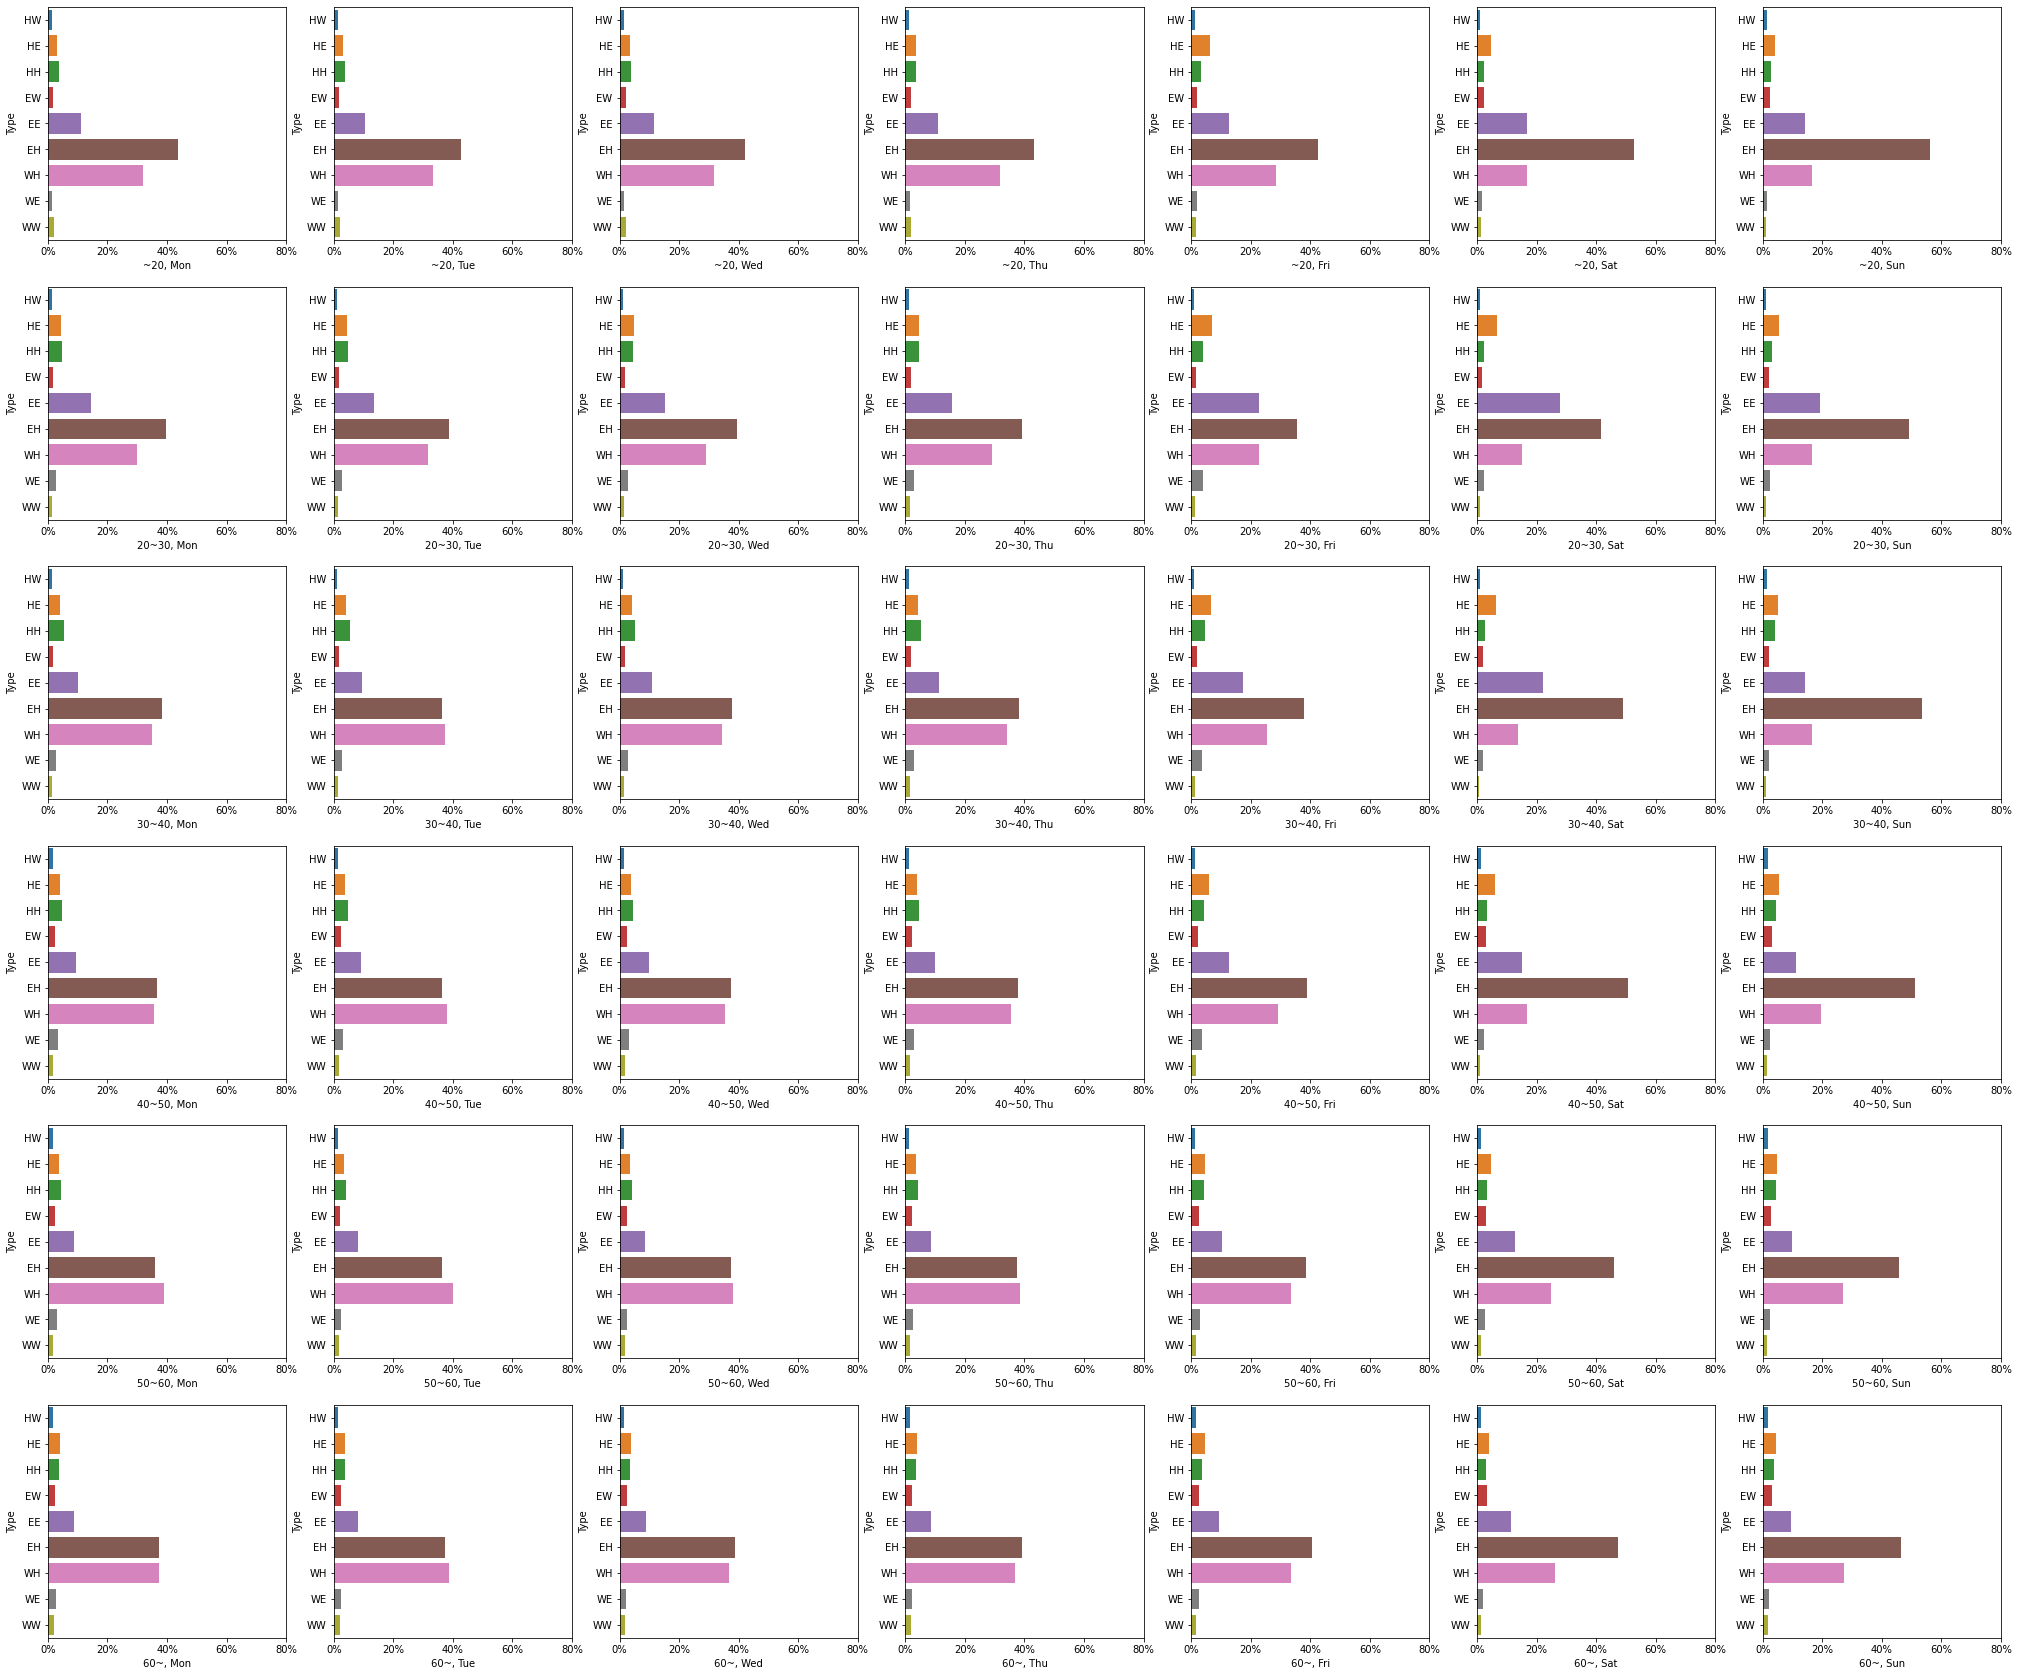

In [ ]:
# H : 야간상주지 / W : 주간상주지 / E : H&W가 아닌 곳

case_list = df['이동유형'].unique()
case_list.sort()
case_list = ['HW', 'HE', 'HH', 'EW', 'EE', 'EH', 'WH', 'WE', 'WW']
fig, axes = plt.subplots(6, 7, figsize=(35, 30))

for i, f1 in enumerate(day_list):
    for j, f2 in enumerate(age_list):

        if j == 0:
            idx_ = (df['요일'] == f1[0]) & (df['나이'] < 20)
        else:
            idx_ = (df['요일'] == f1[0]) & (10*(j+1) <= df['나이']) & (df['나이'] < 10*(j+2))
        
        df_1 = df.loc[idx_, :].copy()

        df_1['이동인구(합)'] = df_1['이동인구(합)'].astype(float)
        df_2 = df_1.groupby('이동유형')['이동인구(합)'].apply(sum)
        df_2 = df_2.reset_index()

        total_sum = df_2['이동인구(합)'].sum()
        df_2['이동인구(합)'] = df_2['이동인구(합)'].mul(100/total_sum)

        graph = sns.barplot(y='이동유형',
                            x='이동인구(합)',
                            data=df_2,
                            order=case_list,
                            ax=axes[j][i]
)
        graph.set(xlim=(0, 80))
        graph.xaxis.set_major_formatter(mtick.PercentFormatter())
        graph.set_xlabel(age_list[j]+', '+day_list[i][1])
        graph.set_ylabel('Type')

# 09시 기준 8월 데이터  

### 시각화 주안점
- 비교를 위해 Percentage로 표현
- 정보 왜곡 방지를 위해 모든 그래프 x tick 동일하게 고정  


### 평일, 주말 간 차이 분석
    H : 야간상주지(집 등), W : 주간상주지(학교, 회사 등), E : 주&야 상주지 제외한 곳
- 평일에 HW(야간상주지 -> 주간상주지) 비율이 주말보다 높음  


In [4]:
fname_list = os.listdir("/content/drive/MyDrive/DL_data/DACON6/서울시 인구 이동/서울시 8월 생활이동데이터")

fname_list.sort()
fname_list = fname_list
current_dir = '/content/drive/MyDrive/DL_data/DACON6/서울시 인구 이동/서울시 8월 생활이동데이터/'

for fname in fname_list:

    fig = ''
    axes = ''

    file_dir = current_dir + fname

    df = pd.read_csv(file_dir, encoding='cp949')

    idx = df['이동인구(합)']=="*"
    df['이동인구(합)'][idx] = '1.0'

    day_list = [['월','Mon'], ['화','Tue'], ['수','Wed'], ['목','Thu'], ['금','Fri'], ['토','Sat'], ['일','Sun']]
    age_list = ['~20','20~30','30~40','40~50','50~60','60~']

    case_list = df['이동유형'].unique()
    case_list.sort()
    case_list = ['HW', 'HE', 'HH', 'EW', 'EE', 'EH', 'WH', 'WE', 'WW']
    fig, axes = plt.subplots(6, 7, figsize=(35, 30))

    for i, f1 in enumerate(day_list):
        for j, f2 in enumerate(age_list):

            if j == 0:
                idx_ = (df['요일'] == f1[0]) & (df['나이'] < 20)
            else:
                idx_ = (df['요일'] == f1[0]) & (10*(j+1) <= df['나이']) & (df['나이'] < 10*(j+2))
            
            df_1 = df.loc[idx_, :].copy()

            df_1['이동인구(합)'] = df_1['이동인구(합)'].astype(float)
            df_2 = df_1.groupby('이동유형')['이동인구(합)'].apply(sum)
            df_2 = df_2.reset_index()

            total_sum = df_2['이동인구(합)'].sum()
            df_2['이동인구(합)'] = df_2['이동인구(합)'].mul(100/total_sum)

            graph = sns.barplot(y='이동유형',
                                x='이동인구(합)',
                                data=df_2,
                                order=case_list,
                                ax=axes[j][i]
    )
            graph.set(xlim=(0, 80))
            graph.xaxis.set_major_formatter(mtick.PercentFormatter())
            graph.set_xlabel(age_list[j]+', '+day_list[i][1])
            graph.set_ylabel('Type')
    
    plt.savefig(fname + '.png')

Output hidden; open in https://colab.research.google.com to view.

In [3]:
fname_list = os.listdir("/content/drive/MyDrive/DL_data/DACON6/서울시 인구 이동/서울시 8월 생활이동데이터")

fname_list.sort()
fname_list

['생활이동_행정동_2022.08_00시.csv',
 '생활이동_행정동_2022.08_01시.csv',
 '생활이동_행정동_2022.08_02시.csv',
 '생활이동_행정동_2022.08_03시.csv',
 '생활이동_행정동_2022.08_04시.csv',
 '생활이동_행정동_2022.08_05시.csv',
 '생활이동_행정동_2022.08_06시.csv',
 '생활이동_행정동_2022.08_07시.csv',
 '생활이동_행정동_2022.08_08시.csv',
 '생활이동_행정동_2022.08_09시.csv',
 '생활이동_행정동_2022.08_10시.csv',
 '생활이동_행정동_2022.08_11시.csv',
 '생활이동_행정동_2022.08_12시.csv',
 '생활이동_행정동_2022.08_13시.csv',
 '생활이동_행정동_2022.08_14시.csv',
 '생활이동_행정동_2022.08_15시.csv',
 '생활이동_행정동_2022.08_16시.csv',
 '생활이동_행정동_2022.08_17시.csv',
 '생활이동_행정동_2022.08_18시.csv',
 '생활이동_행정동_2022.08_19시.csv',
 '생활이동_행정동_2022.08_20시.csv',
 '생활이동_행정동_2022.08_21시.csv',
 '생활이동_행정동_2022.08_22시.csv',
 '생활이ᄃ

In [ ]:
current_dir = os.getcwd('/content/drive/MyDrive/DL_data/DACON6/서울시 인구 이동/서울시 8월 생활이동데이터/')
day_list = [['월','Mon'], ['화','Tue'], ['수','Wed'], ['목','Thu'], ['금','Fri'], ['토','Sat'], ['일','Sun']]
age_list = ['~20','20~30','30~40','40~50','50~60','60~']



for fname in fname_list:
    file_dir = current_dir + fname
    df = pd.read_csv(file_dir, encoding='cp949')

    idx_ = (df['나이'] >= 65)

    df_1 = df[idx_, ['도착시간', '요일', '이동유형', '이동인구(합)']].copy()
    
    idx = df_1['이동인구(합)']=="*"
    df_1['이동인구(합)'][idx] = '1.0'


    df_1['이동인구(합)'] = df_1['이동인구(합)'].astype(float)
    df_2 = df_1.groupby('이동유형')['이동인구(합)'].apply(sum)
    df_2 = df_2.reset_index()

    total_sum = df_2['이동인구(합)'].sum()
    df_2['이동인구(합)'] = df_2['이동인구(합)'].mul(100/total_sum)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
mpg = sns.load_dataset('mpg')
def f(x):
    img = sns.countplot(mpg[mpg['mpg']<x]['origin']) 
    plt.title('Origin Countplot mpg = {}'.format(x))
    return img
  
interact(f, x=28)

NameError: ignored